In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

import exoplanet as xo
from specgp.terms import KroneckerTerm
from specgp.means import ConstantMean, CustomMean 
from specgp.distributions import MvUniform

Start by loading the traces from our MCMC analysis of the SOHO data:

In [2]:
with pm.Model() as model:
    trace = pm.load_trace('../../docs/tutorials/.pymc_1.trace')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)

We'll use these values to simulate sun-like light curves:

In [3]:
term1 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][0], 
                            log_w0=mu["logw"][0], 
                            log_Q=-np.log(np.sqrt(2))
                            )
term2 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][1], 
                            log_w0=mu["logw"][1], 
                            log_Q=-np.log(np.sqrt(2))
                            )
term3 = xo.gp.terms.SHOTerm(log_S0=mu["logS0"][2], 
                            log_w0=mu["logw"][2], 
                            log_Q=mu["logQ"]
                            )
alpha1 = np.exp([0, mu["alpha1"][0], mu["alpha2"][0]])
alpha2 = np.exp([0, mu["alpha1"][1], mu["alpha2"][1]])
alpha3 = np.exp([0, mu["alpha1"][2], mu["alpha2"][2]])
kernel = (KroneckerTerm(term1, alpha1) + 
          KroneckerTerm(term2, alpha2) + 
          KroneckerTerm(term3, alpha3))

t = np.linspace(-1, 1, 1000)
diag = np.exp(2*mu["logsig"])[:, None] * np.ones((3, len(t)))
gp = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=ConstantMean(mu["mean"]), J=6)

generate and plot simulated data!

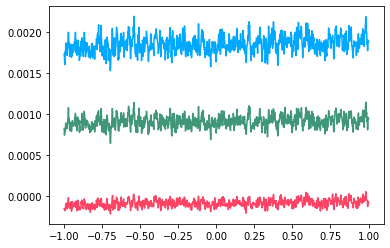

In [4]:
n = np.random.randn(3*len(t), 1)
y = gp.dot_l(n).eval() / 1e3
r, g, b = [y[i::3] for i in range(3)]

colors = ['#FE4365', '#3F9778', '#00A9FF', '#ECA25C', '#005D7F']
pl.plot(t, r, '-', color=colors[0])
pl.plot(t, g+0.001, '-', color=colors[1])
pl.plot(t, b+0.002, '-', color=colors[2])

Add a transit with ``starry``:

In [5]:
orbit = xo.orbits.KeplerianOrbit(period=5.0)
u = [0.3, 0.2]
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.002, t=t+0.25, texp=0.02)
    .eval()
)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

[Text(0.5, 0, 'time (days)'), Text(0.5, 0, 'time (days)')]

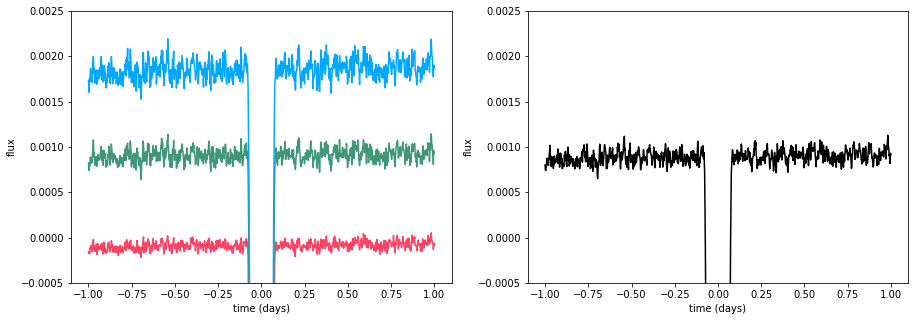

In [6]:
fig, ax = pl.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t, r + planet + moon, '-', color=colors[0])
ax[0].plot(t, g+0.001 + planet + moon, '-', color=colors[1])
ax[0].plot(t, b+0.002+ planet + moon, '-', color=colors[2])
ax[0].set_ylim(-0.0005, 0.0025)

ax[1].plot(t, np.mean([r, g, b], axis=0)+0.001 + planet + moon, '-', color='k')
ax[1].set_ylim(-0.0005, 0.0025)

[x.set_ylabel('flux') for x in ax]
[x.set_xlabel('time (days)') for x in ax]

Let's do inference on each of these separately and see how the results compare. First, the multiband light curve: 

In [ ]:
with pm.Model() as model:
    
    logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=3)
    logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=3)
    logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"])
    alpha1 =  pm.MvNormal("alpha1", mu=mu["alpha1"], 
                          chol=np.diag(sig["alpha1"]), shape=3)
    alpha2 =  pm.MvNormal("alpha2", mu=mu["alpha2"], 
                          chol=np.diag(sig["alpha2"]), shape=3)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=3)
    u = MvUniform("u", lower=[0, 0], upper=[1, 1], testval=[0.5, 0.5])
    r = MvUniform("r", lower=[0, 0], upper=[1, 1], testval=[0.1, 0.002])
    
    mean = lambda x: (xo.LimbDarkLightCurve(u)
                          .get_light_curve(orbit=orbit, r=r[0], t=x, texp=0.02) + 
                      xo.LimbDarkLightCurve(u)
                          .get_light_curve(orbit=orbit, r=r[1], t=x+0.25, texp=0.02))
    
    term0 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[0],
        log_w0 = logw[0],
        log_Q = -np.log(np.sqrt(2))
    )
    term1 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[1],
        log_w0 = logw[1],
        log_Q = -np.log(np.sqrt(2))
    )
    term2 = xo.gp.terms.SHOTerm(
        log_S0 = logS0[2],
        log_w0 = logw[2],
        log_Q = logQ
    )
        
    q0 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    q1 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
    q2 = tt.exp(tt.stack([0.0, alpha1[2], alpha2[2]]))
        
    kernel = (KroneckerTerm(term0, q0) + 
              KroneckerTerm(term1, q1) + 
              KroneckerTerm(term2, q2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=6, mean=CustomMean([mean, mean, mean]))
    gp.marginal("gp", observed = y.T)
        
    start = model.test_point
    map_soln = xo.optimize(start=start, verbose=True)
    start = map_soln
    
    # comment this out if you don't want to run the mcmc right now.
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [r, u, logsig, alpha2, alpha1, logQ, logw, logS0]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

message: Desired error not necessarily achieved due to precision loss.
logp: 9265.939387430833 -> 9815.711293332091
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, u, logsig, alpha2, alpha1, logQ, logw, logS0]
Sampling 2 chains, 238 divergences:  51%|█████     | 2024/4000 [04:22<08:36,  3.83draws/s]

In [ ]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

In [ ]:
trace.get_values('u')